Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

**Link to GitHub repo with .ipynb file- https://github.com/prajwalseth/Advanced-Machine-Learning**

# Import data

In [19]:
# Import data and unzip files to folder
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip 

Downloading...
From: https://drive.google.com/uc?id=1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
To: /content/COVID-19_Radiography_Database.zip
1.22GB [00:09, 133MB/s] 
Archive:  COVID-19_Radiography_Database.zip
  inflating: COVID-19 Radiography Database/COVID.metadata.xlsx  
   creating: COVID-19 Radiography Database/COVID/
  inflating: COVID-19 Radiography Database/COVID/COVID (1).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (10).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (100).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1000).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1001).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1002).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1003).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1004).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1005).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1006).png  
  inflati

# Initial setup and visualization of images from different categories

In [1]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [102]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
import pprint

In [3]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (410).png', 'COVID-19 Radiography Database/COVID/COVID (213).png', 'COVID-19 Radiography Database/COVID/COVID (597).png', 'COVID-19 Radiography Database/COVID/COVID (119).png', 'COVID-19 Radiography Database/COVID/COVID (634).png', 'COVID-19 Radiography Database/COVID/COVID (1187).png', 'COVID-19 Radiography Database/COVID/COVID (610).png', 'COVID-19 Radiography Database/COVID/COVID (167).png', 'COVID-19 Radiography Database/COVID/COVID (510).png', 'COVID-19 Radiography Database/COVID/COVID (655).png', 'COVID-19 Radiography Database/COVID/COVID (700).png', 'COVID-19 Radiography Database/COVID/COVID (1092).png', 'COVID-19 Radiography Database/COVID/COVID (250).png', 'COVID-19 Radiography Database/COVID/COVID (15).png', 'COVID-19 Radiography Database/COVID/COVID (1060).png', 'COVID-19 Radiography Database/COVID/COVID (1105).png', 'COVID-19 Radiography Database/COVID/COVID (64).png', 'COVID

In [4]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

(192, 192, 3)

In [5]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [6]:
len(image_filepaths)

3886

In [7]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [8]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


Covid positive


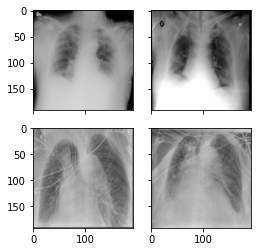

Viral pneumonia


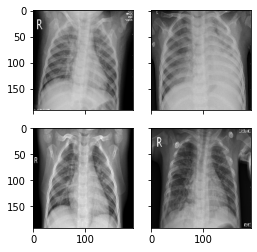

Normal


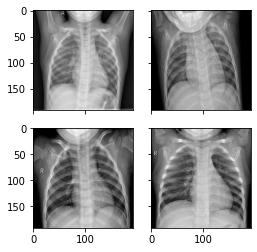

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

print('Covid positive')
im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png')
im2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (10).png')
im3 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1000).png')
im4 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1015).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

print('Viral pneumonia')
im1 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1).png')
im2 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (10).png')
im3 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1000).png')
im4 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1015).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()
        
print('Normal')
im1 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1).png')
im2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (10).png')
im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (100).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1015).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()


In [10]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

# Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.


The COVID-19 Radiography Dataset contains a mixture of 423 COVID-19, 1485 viral pneumonia, and 1579 normal chest X-ray images. Building a predictive model using this dataset could be helpful as it can enable doctors to tell whether or not a patient has COVID-19 just by looking at an X-ray scan of their chest. This can help speed up the time taken to diagnose a patient with COVID-19. It can also help differentiate cases of COVID-19 from other diseases such as viral pneumonia, which would require different medications and treatments.

# Model 1 (Sequential)

In [12]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 20, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3108 samples, validate on 778 samples
Epoch 1/20
3108/3108 [==============================] - 13s 4ms/sample - loss: 0.6271 - acc: 0.7227 - val_loss: 0.2911 - val_acc: 0.8843
Epoch 2/20
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.2859 - acc: 0.9009 - val_loss: 0.2315 - val_acc: 0.9152
Epoch 3/20
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.2101 - acc: 0.9279 - val_loss: 0.2537 - val_acc: 0.9075
Epoch 4/20
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.1815 - acc: 0.9369 - val_loss: 0.2375 - val_acc: 0.9126
Epoch 5/20
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.1534 - acc: 0.9463 - val_loss: 0.2213 - val_acc: 0.9216
Epoch 6/20
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.1423 - acc: 0.9537 - val_loss: 0.1659 - val_acc: 0.9422
Epoch 7/20
3108/3108 [==============================] -

# Submit Model 1

In [13]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
Requirement already up-to-date: aimodelshare in /usr/local/lib/python3.7/dist-packages (0.0.61)


In [14]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 0 0 0 1 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 1 1 2 1 1 0 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 1 2 2 2 0 2 1 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 1 2 2 1 2 1 2 1 1 0 2 0 2 0 1 2 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 1 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 1 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 1 0 2 1 2
 2 0 1 0 0 0 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 2 0
 1 0 2 2 1 1 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 2 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 0 2 0 2 1 1 2 0 1 1 2 0 0 2 0 0 1 1 2 2 0 0 1 2 2 0 1 0 0 1
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 1 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 2 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [15]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels


In [16]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.96144,0.961777,0.961777,0.961777,0,0,0,0


In [17]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

Using TensorFlow backend.


In [18]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 64 -> 30


In [19]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [20]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [21]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 46'

In [22]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,timestamp,version
0,0.992288,0.992486,0.992412,0.992565,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers': [{'name': 'inpu...",dv2438,2021-03-07 23:02:41.978914,45
1,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:49:57.183806,7
2,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:50:38.718996,8
3,0.980720,0.981091,0.981226,0.981263,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers': [{'name': 'inpu...",dv2438,2021-03-06 16:06:55.748014,26
4,0.975578,0.976024,0.975700,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-07 08:55:54.375970,40
5,0.970437,0.971197,0.971771,0.970751,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': [{'name': 'input...",mro9395,2021-03-05 21:57:59.450067,22
6,0.970437,0.971197,0.971771,0.970751,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': [{'name': 'input...",mro9395,2021-03-05 20:15:43.157299,18
7,0.970437,0.970832,0.971658,0.971350,keras,True,True,Model,34,20232011,str,Adam,"{'name': 'model_15', 'layers': [{'name': 'inpu...",dv2438,2021-03-06 16:39:11.399010,28
8,0.969152,0.969911,0.969798,0.970110,keras,True,True,Sequential,4,7082307,str,SGD,"{'name': 'sequential_1', 'layers': [{'class_na...",xcin,2021-03-06 00:40:02.012375,23
9,0.969152,0.969567,0.969122,0.970260,keras,True,True,Sequential,5,14423555,str,SGD,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-07 08:41:14.289940,39


In [23]:
ai.stylize_leaderboard(data,category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,version
0,99.23%,99.25%,99.24%,99.26%,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers':...",dv2438,45
1,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,7
2,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,8
3,98.07%,98.11%,98.12%,98.13%,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers':...",dv2438,26
4,97.56%,97.60%,97.57%,97.65%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,40
5,97.04%,97.12%,97.18%,97.08%,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,22
6,97.04%,97.12%,97.18%,97.08%,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,18
7,97.04%,97.08%,97.17%,97.13%,keras,True,True,Model,34,20232011,str,Adam,"{'name': 'model_15', 'layers':...",dv2438,28
8,96.92%,96.99%,96.98%,97.01%,keras,True,True,Sequential,4,7082307,str,SGD,"{'name': 'sequential_1', 'laye...",xcin,23
9,96.92%,96.96%,96.91%,97.03%,keras,True,True,Sequential,5,14423555,str,SGD,"{'name': 'sequential_1', 'laye...",prajseth,39


# Model 2 (Transfer Learning using vgg16)

In [83]:
# Quick explantory example before full code examples below
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [84]:
# example of loading the vgg16 model
from tensorflow.keras.applications import VGG16
# load model
model = VGG16()

# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [85]:
# example of loading the vgg16 model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [86]:
# Next step: Freeze the weights of the VGG19 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [87]:
from keras.regularizers import l2
model = Sequential([
  base_model,
   Conv2D(512,(1,1),padding="same", activation="relu"),
   Conv2D(1024,(3,3),padding="same", activation="relu"),
   Conv2D(1024,(3,3),padding="same", activation="relu"),
   GlobalAveragePooling2D(),
   Dense(3,activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
conv2d_570 (Conv2D)          (None, 6, 6, 512)         262656    
_________________________________________________________________
conv2d_571 (Conv2D)          (None, 6, 6, 1024)        4719616   
_________________________________________________________________
conv2d_572 (Conv2D)          (None, 6, 6, 1024)        9438208   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 3075      
Total params: 29,138,243
Trainable params: 14,423,555
Non-trainable params: 14,714,688
_________________________________

In [88]:

# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Train on 3108 samples, validate on 778 samples
Epoch 1/5
3107/3108 [============================>.] - ETA: 0s - loss: 0.5203 - acc: 0.8140
Epoch 00001: val_acc improved from -inf to 0.91003, saving model to best_model.h5
3108/3108 [==============================] - 103s 33ms/sample - loss: 0.5201 - acc: 0.8140 - val_loss: 0.2132 - val_acc: 0.9100
Epoch 2/5
3107/3108 [============================>.] - ETA: 0s - loss: 0.2341 - acc: 0.9186
Epoch 00002: val_acc improved from 0.91003 to 0.94602, saving model to best_model.h5
3108/3108 [==============================] - 87s 28ms/sample - loss: 0.2340 - acc: 0.9186 - val_loss: 0.1419 - val_acc: 0.9460
Epoch 3/5
3106/3108 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9427
Epoch 00003: val_acc did not improve from 0.94602
3108/3108 [==============================] - 86s 28ms/sample - loss: 0.1651 - acc: 0.9427 - val_loss: 0.1574 - val_acc: 0.9447
Epoch 4/5
3107/3108 [============================>.] - ETA: 0s - loss: 0.1690 

In [90]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.001, 0.001, 0.001, 0.001, 0.001]
5


# Submit Model 2 (not working due to some onnx error)

In [91]:
# test with aimodelshare library
!pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
Requirement already up-to-date: aimodelshare in /usr/local/lib/python3.7/dist-packages (0.0.61)


In [92]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata




[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 1 1 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 1 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 1 2 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 1 2 2 1 2 1 2 1 1 0 2 0 2 0 1 2 2 1 0 0 0 2 0 1 0 0 1 1 2 1 2 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 2 2 2 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 1 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 2 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 1 1 2 1 1 1 0 2 0 1 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 1 0 2 1 2
 2 0 1 0 2 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 2 0
 1 0 2 2 1 0 2 2 0 0 2 0 1 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 1 2 0 2 1 1 2 0 1 1 2 0 0 2 2 2 1 1 2 2 0 0 1 2 2 0 1 0 0 1
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 2 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 2 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 2 2 

In [93]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels


In [94]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.965296,0.965941,0.967306,0.965045,0,0,0,0


In [95]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

In [96]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=True,
                                   deep_learning=True,
                                   task_type='classification',)

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

AssertionError: ignored

In [ ]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

In [ ]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [ ]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

In [ ]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

In [ ]:
ai.stylize_leaderboard(data,category="classification")

# Model 3 (Transfer Learning using InceptionV3 and imagenet weights)

In [63]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_476 (Conv2D)             (None, 95, 95, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 95, 95, 32)   96          conv2d_476[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 95, 95, 32)   0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

In [52]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_288 (Conv2D)             (None, 95, 95, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 95, 95, 32)   96          conv2d_288[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 95, 95, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [64]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_476 (Conv2D)             (None, 95, 95, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 95, 95, 32)   96          conv2d_476[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 95, 95, 32)   0           batch_normalization_470[0][0]    
____________________________________________________________________________________________

In [71]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_data=(X_test,y_test)) # I ran this code block 4 times, so 20 epochs in total

Train on 3108 samples, validate on 778 samples
Epoch 1/5
3108/3108 [==============================] - 34s 11ms/sample - loss: 0.1237 - acc: 0.9588 - val_loss: 1.6356 - val_acc: 0.7841
Epoch 2/5
3108/3108 [==============================] - 21s 7ms/sample - loss: 0.1440 - acc: 0.9559 - val_loss: 1058.8220 - val_acc: 0.3766
Epoch 3/5
3108/3108 [==============================] - 21s 7ms/sample - loss: 0.0900 - acc: 0.9698 - val_loss: 1.3870 - val_acc: 0.8496
Epoch 4/5
3108/3108 [==============================] - 21s 7ms/sample - loss: 0.0435 - acc: 0.9849 - val_loss: 0.1481 - val_acc: 0.9563
Epoch 5/5
3108/3108 [==============================] - 21s 7ms/sample - loss: 0.0267 - acc: 0.9910 - val_loss: 0.0728 - val_acc: 0.9794


# Submit Model 3

In [72]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
Requirement already up-to-date: aimodelshare in /usr/local/lib/python3.7/dist-packages (0.0.61)


In [73]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata




[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 0 0 1 1 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 1 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 0 0 1 1 1 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 1 2 2 1 2 1 2 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 1 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 1 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 1 0 2 1 2
 2 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 2 0
 1 0 2 2 1 0 2 2 0 0 2 0 1 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 1 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 2 1 2 2 2 2 1 2 1 2 1 1 1 2 1 1 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [74]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels


In [75]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.979434,0.97971,0.979604,0.980173,0,0,0,0


In [76]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

In [77]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=True,
                                   deep_learning=True,
                                   task_type='classification',)

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 831 -> 223


In [78]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [79]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [80]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 50'

In [81]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,timestamp,version
0,0.992288,0.992486,0.992412,0.992565,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers': [{'name': 'inpu...",dv2438,2021-03-07 23:02:41.978914,45
1,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:50:38.718996,8
2,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:49:57.183806,7
3,0.983290,0.983636,0.983446,0.983891,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:43:34.857578,48
4,0.980720,0.981091,0.981226,0.981263,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers': [{'name': 'inpu...",dv2438,2021-03-06 16:06:55.748014,26
5,0.979434,0.979710,0.979604,0.980173,keras,True,True,Model,313,21808931,str,Adam,"{'name': 'model_4', 'layers': [{'name': 'input...",prajseth,2021-03-08 02:34:38.630185,50
6,0.978149,0.978550,0.978470,0.978635,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:50:31.207727,49
7,0.975578,0.976001,0.975782,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:39:11.372915,47
8,0.975578,0.976024,0.975700,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-07 08:55:54.375970,40
9,0.970437,0.971197,0.971771,0.970751,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': [{'name': 'input...",mro9395,2021-03-05 20:15:43.157299,18


In [82]:
ai.stylize_leaderboard(data,category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,version
0,99.23%,99.25%,99.24%,99.26%,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers':...",dv2438,45
1,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,8
2,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,7
3,98.33%,98.36%,98.34%,98.39%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,48
4,98.07%,98.11%,98.12%,98.13%,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers':...",dv2438,26
5,97.94%,97.97%,97.96%,98.02%,keras,True,True,Model,313,21808931,str,Adam,"{'name': 'model_4', 'layers': ...",prajseth,50
6,97.81%,97.85%,97.85%,97.86%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,49
7,97.56%,97.60%,97.58%,97.65%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,47
8,97.56%,97.60%,97.57%,97.65%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,40
9,97.04%,97.12%,97.18%,97.08%,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,18


# Discuss which models performed better and point out relevant hyper-parameter values for successful models.


Here are the f1 scores for the three models in descending order-

* Model 3's f1 score: 0.97971	

* Model 2's f1 score: 0.965941

* Model 1's f1 score: 0.961777




My best submission for Model 3 (InceptionV3 with ImageNet weights) had:

* Total params: 21,808,931

* Trainable params: 21,774,499

* Non-trainable params: 34,432



In [118]:
data.loc[5]

accuracy                                                      0.979434
f1_score                                                       0.97971
precision                                                     0.979604
recall                                                        0.980173
ml_framework                                                     keras
transfer_learning                                                 True
deep_learning                                                     True
model_type                                                       Model
depth                                                              313
num_params                                                    21808931
loss                                                               str
optimizer                                                         Adam
model_config         {'name': 'model_4', 'layers': [{'name': 'input...
username                                                      prajseth
timest

In [123]:
# Uncomment the following lines to get the hyperparameters for all layers
pp = pprint.PrettyPrinter()
pp.pprint(data.loc[5]['model_config'])

("{'name': 'model_4', 'layers': [{'name': 'input_12', 'class_name': "
 "'InputLayer', 'config': {'batch_input_shape': (None, 192, 192, 3), 'dtype': "
 "'float32', 'sparse': False, 'ragged': False, 'name': 'input_12'}, "
 "'inbound_nodes': []}, {'name': 'conv2d_476', 'class_name': 'Conv2D', "
 "'config': {'name': 'conv2d_476', 'trainable': True, 'dtype': 'float32', "
 "'filters': 32, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'valid', "
 "'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': "
 "'linear', 'use_bias': False, 'kernel_initializer': {'class_name': "
 "'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, "
 "'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, "
 "'kernel_regularizer': None, 'bias_regularizer': None, "
 "'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': "
 "None}, 'inbound_nodes': [[['input_12', 0, 0, {}]]]}, {'name': "
 "'batch_normalization_470', 'class_name': 'BatchNor


If you look at the leaderboard, my best submission is actually a version of Model 2. ONNX was giving me an error when I tried to submit that model today, but I was able to submit it yesterday. It had:

* Total params: 29,138,243

* Trainable params: 14,423,555

* Non-trainable params: 14,714,688

The f1 score for this model was 0.983636.


In [116]:
data.loc[3]

accuracy                                                       0.98329
f1_score                                                      0.983636
precision                                                     0.983446
recall                                                        0.983891
ml_framework                                                     keras
transfer_learning                                                 True
deep_learning                                                     True
model_type                                                  Sequential
depth                                                                5
num_params                                                    14423555
loss                                                               str
optimizer                                                         Adam
model_config         {'name': 'sequential_1', 'layers': [{'class_na...
username                                                      prajseth
timest

In [124]:
#Uncomment the following lines to get the hyperparameters for all layers
pp.pprint(data.loc[3]['model_config'])

("{'name': 'sequential_1', 'layers': [{'class_name': 'Model', 'config': "
 "{'name': 'vgg16', 'layers': [{'name': 'input_3', 'class_name': 'InputLayer', "
 "'config': {'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', "
 "'sparse': False, 'ragged': False, 'name': 'input_3'}, 'inbound_nodes': []}, "
 "{'name': 'block1_conv1', 'class_name': 'Conv2D', 'config': {'name': "
 "'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, "
 "'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': "
 "'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': "
 "True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': "
 "{'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': "
 "'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, "
 "'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': "
 "None, 'bias_constraint': None}, 'inbound_nodes': [[['input_3', 0, 0, {}]]]